In [98]:
from typing import Callable, Tuple
from finite_distributions.FiniteDistribution import FiniteDistribution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sinkhorn.SinkhornRunner as SinkhornRunner
import sinkhorn.SinkhornKernels as skern
import visualizer.joint_distribution_visualizer as jdv
import bisect

In [99]:
def gaussian_prob(mu: float, sigma: float, x: float):
    return np.exp(-(x - mu)**2 / (2 * sigma * sigma))

In [100]:
def transport_map(mu_1: float, sigma_1: float, mu_2: float, sigma_2: float, x: float) -> float:
    return mu_2 + (sigma_2 / sigma_1) * (x - mu_1)

In [101]:
mu_1 = 1.0
sigma_1 = 1.0

mu_2 = 0.0
sigma_2 = 2.0

In [102]:
xs = [round(x, 5) for x in np.linspace(-5, 5, 50)]

In [103]:
s1 = np.sum([gaussian_prob(mu_1, sigma_1, x) for x in xs])
s2 = np.sum([gaussian_prob(mu_2, sigma_2, x) for x in xs])

dist_1 = FiniteDistribution({x: gaussian_prob(mu_1, sigma_1, x) / s1 for x in xs})
dist_2 = FiniteDistribution({x: gaussian_prob(mu_2, sigma_2, x) / s2 for x in xs})

In [ ]:
c = lambda x, y: 0.5*(x - y)**2

In [ ]:
# p-norm
p = 2.
if (np.abs(p - 2.) < 1e-12):
    sinkhorn_runner = skern.get_quadratically_regularized_runner(c, use_parallelization=False)
else:
    sinkhorn_runner = skern.get_pnorm_regularized_runner(p, c)

epsilons = [0.001, 0.01, 0.1, 1.0, 10.0]
delta = 0.01

outputs = {}
for epsilon in epsilons:
    outputs[epsilon] = sinkhorn_runner.run_sinkhorn(dist_1, dist_2, epsilon, delta)

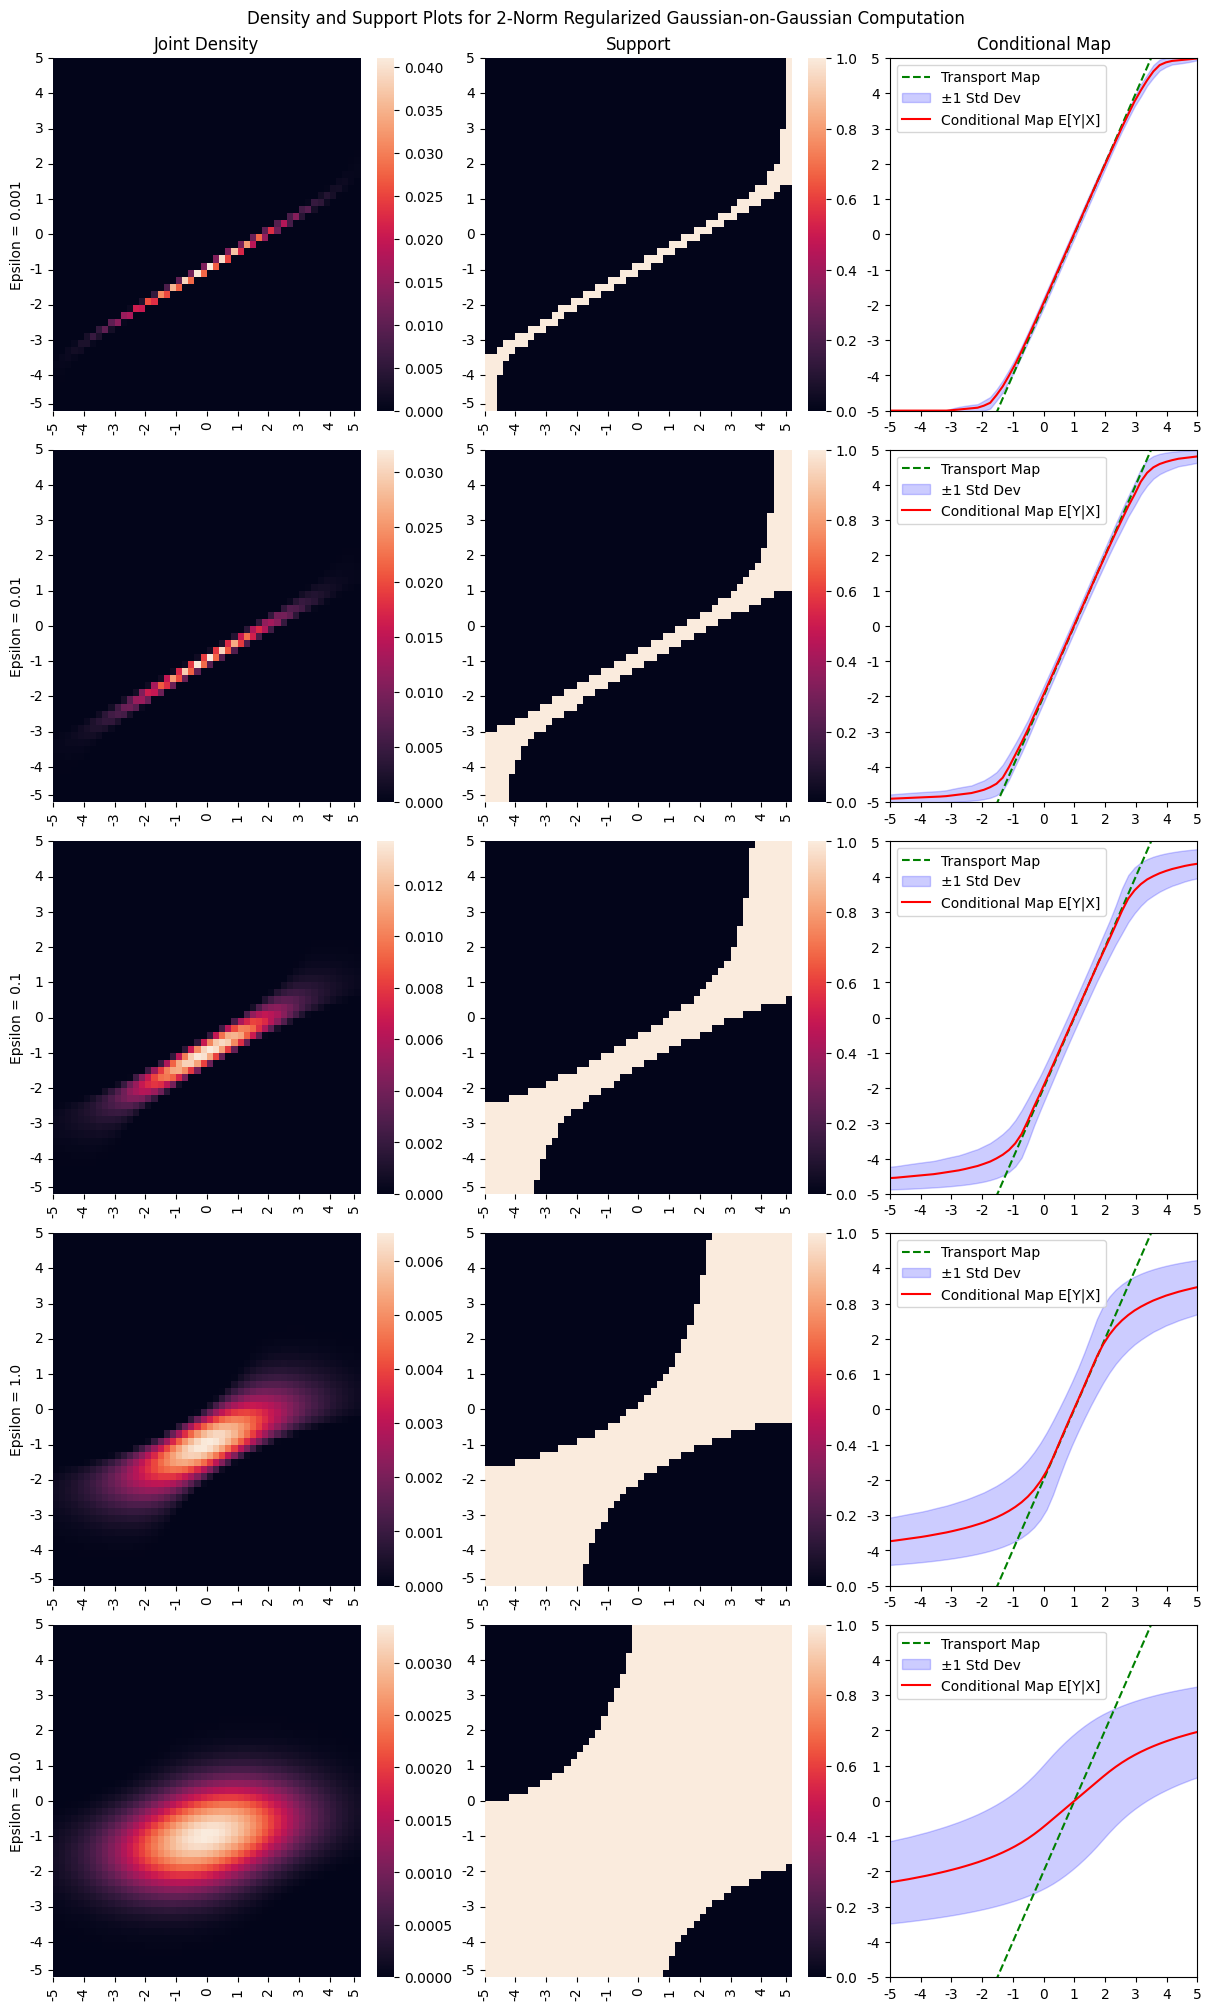

In [ ]:
fig, axes = plt.subplots(nrows=len(epsilons), ncols=3, figsize=(12, 20), constrained_layout=True)  # 5 rows, 2 cols
axes = axes.flatten()

for i in range(len(epsilons)):
    epsilon = epsilons[i]
    pi = outputs[epsilon][0]

    tick_values = np.arange(-5, 6, 1)
    tick_indices = [bisect.bisect_left(xs, val) for val in tick_values]
    x_ticks_tuples = (tick_indices, tick_values)
    y_ticks_tuples = (list(tick_indices), list(reversed(tick_values)))

    conditional_map = pi.calculate_conditional_map()
    conditional_ys = np.array([conditional_map[x] for x in xs])
    
    stdevs = []
    for x in xs:
        conditional_avg = conditional_map[x]
        total_probability = np.sum([pi.get_probability(tup) for tup in (pi.get_keys()) if tup[0] == x])
        marginal_probabilities = np.array([pi.get_probability((x, y)) for y in xs])/total_probability
        variance = np.sum(((xs - conditional_avg)**2) * marginal_probabilities)
        stdev = np.sqrt(variance)
        stdevs.append(stdev)
    stdevs = np.array(stdevs)


    jdv.visualize_joint_probability(pi, support_only_threshold = None, xticks = x_ticks_tuples, yticks = y_ticks_tuples, ax = axes[3 * i], show = False, ylabel_to_set = "", xlabel_to_set="", reverse_sort_y_axis = True)
    axes[3*i].set_ylabel(f"Epsilon = {epsilon}")
    jdv.visualize_joint_probability(pi, support_only_threshold = 1e-12,  xticks = x_ticks_tuples, yticks = y_ticks_tuples, ax = axes[3 * i + 1], show = False, ylabel_to_set = "", xlabel_to_set="", reverse_sort_y_axis = True)
    
    axes[3*i+2].plot(xs, [transport_map(mu_1, sigma_1, mu_2, sigma_2, x) for x in xs], color = 'green', linestyle = 'dashed', label = 'Transport Map')
    axes[3*i+2].fill_between(xs, conditional_ys - stdevs, conditional_ys + stdevs, color='blue', alpha=0.2, label='±1 Std Dev')
    axes[3*i+2].plot(xs, conditional_ys, color = 'red', label = 'Conditional Map E[Y|X]')
    axes[3*i+2].set_xlim((min(xs), max(xs)))
    axes[3*i+2].set_ylim((min(xs), max(xs)))
    axes[3*i+2].set_xticks(x_ticks_tuples[1])
    axes[3*i+2].set_xticklabels(x_ticks_tuples[1])
    axes[3*i+2].set_yticks(y_ticks_tuples[1])
    axes[3*i+2].set_yticklabels(y_ticks_tuples[1])
    axes[3*i+2].set_xlabel("")
    axes[3*i+2].legend()

axes[0].set_title("Joint Density")
axes[1].set_title("Support")
axes[2].set_title("Conditional Map")
plt.suptitle("Density and Support Plots for 2-Norm Regularized Gaussian-on-Gaussian Computation")


plt.savefig("plots/gaussian_on_gaussian_2norm_ot.png", dpi = 300)
plt.show()